# Abstract
In this blog post, I’m taking on an introductory-level machine learning classification task.  This task, classifying penguin species, is a ternary classification problem as there are three species options for which I am trying to construct a classifier model to correctly identify.  The data for this task comes from the Palmer Station and was collected by Dr. Kristen Gorman.  The following analysis begins with some preliminary data visualizations and summary statistics interpretation.  From the preliminary visualizations and statistics table, I’m able to make some initial observations about the difference in penguin features across each species.  The next sections show the initial model and feature selection as well as model refinement to improve the chosen model.  While completing this analysis, I experimented with several different models: a logistic regression model, a decision tree classifier, and a random forest classifier.  I ultimately decided to choose proceed with the random forest classifier model (see the third section in this post).  For feature selection, I initially took an exhaustive search approach.  However, after running into many bugs and difficulties with this approach, I opted to incorporate the use of prebuilt feature selection tools (see second section in this post).  Following a thorough feature selection and cross-validation/model refinement process, I was able to produce a model with nearly $100\%$ testing accuracy.  That is, my model was able to correctly identify all but a single observation from unseen test data (i.e. it made 1 classification error).  In the following sections of this post are more in-depth explanations and analyses of my steps taken in accomplishing this classification task. 

### Accessing the Data

In [23]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Accessing training data
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

# Code below provided by Prof. Chodrow
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

*The `prepare_data(...)` function above was provided by Prof. Chodrow*

In [24]:
# Includuing all additional imports
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

*Including all additional imports*

In [25]:
# Creating a modified dataset for visualization and summary statistics
train_viz = train[train["Sex"] != "."].copy()
train_viz["Culmen Ratio (L/D)"] = train_viz["Culmen Length (mm)"] / train_viz["Culmen Depth (mm)"]
train_viz.dropna()

# Subsetting data by species to make regression plots for flipper length by body mass across each Species
adelie = train_viz[['Species', 'Flipper Length (mm)', 'Body Mass (g)']]
adelie = adelie[adelie['Species'] == 'Adelie Penguin (Pygoscelis adeliae)']
adelie = adelie.dropna(subset = ['Species', 'Flipper Length (mm)', 'Body Mass (g)'])
chinstrap = train_viz[['Species', 'Flipper Length (mm)', 'Body Mass (g)']]
chinstrap = chinstrap[chinstrap['Species'] == 'Chinstrap penguin (Pygoscelis antarctica)']
chinstrap = chinstrap.dropna(subset = ['Species', 'Flipper Length (mm)', 'Body Mass (g)'])
gentoo = train_viz[['Species', 'Flipper Length (mm)', 'Body Mass (g)']]
gentoo = gentoo[gentoo['Species'] == 'Gentoo penguin (Pygoscelis papua)']
gentoo = gentoo.dropna(subset = ['Species', 'Flipper Length (mm)', 'Body Mass (g)'])

*Above, I'm creating a modified dataset for visualization and summary statistics and making three subsets of the visualization data set corresponding to eac penguin species with the specific visualization features selected.  This is later used for linear regression modeling by species.*

## Summary Statistics and Preliminary Visualizations

In [26]:
# Creating linear regression models and calculating r^2 values

## Adelie
c1 = np.polyfit(adelie['Body Mass (g)'], adelie['Flipper Length (mm)'], 1)
p1 = np.polyval(c1, adelie['Body Mass (g)'])
r1 = adelie['Flipper Length (mm)'] - p1
ssr1 = np.sum(r1**2)
sst1 = np.sum((adelie['Flipper Length (mm)'] - np.mean(adelie['Flipper Length (mm)']))**2)
rs1 = 1 - (ssr1 / sst1)

## Chinstrap
c2 = np.polyfit(chinstrap['Body Mass (g)'], chinstrap['Flipper Length (mm)'], 1)
p2 = np.polyval(c2, chinstrap['Body Mass (g)'])
r2 = chinstrap['Flipper Length (mm)'] - p2
ssr2 = np.sum(r2**2)
sst2 = np.sum((chinstrap['Flipper Length (mm)'] - np.mean(chinstrap['Flipper Length (mm)']))**2)
rs2 = 1 - (ssr2 / sst2)

## Gentoo
c3 = np.polyfit(gentoo['Body Mass (g)'], gentoo['Flipper Length (mm)'], 1)
p3 = np.polyval(c3, gentoo['Body Mass (g)'])
r3 = gentoo['Flipper Length (mm)'] - p3
ssr3 = np.sum(r3**2)
sst3 = np.sum((gentoo['Flipper Length (mm)'] - np.mean(gentoo['Flipper Length (mm)']))**2)
rs3 = 1 - (ssr3 / sst3)

*Above, I'm creating a linear regression model of flipper length by body mass for each species (using `np.polyfit`).  I'm also extracting the $R^2$ values (using predictions from `np.polyval` to calculate residuals) for each regression model to include in my plots below.  I searched online how to use these two functions.*

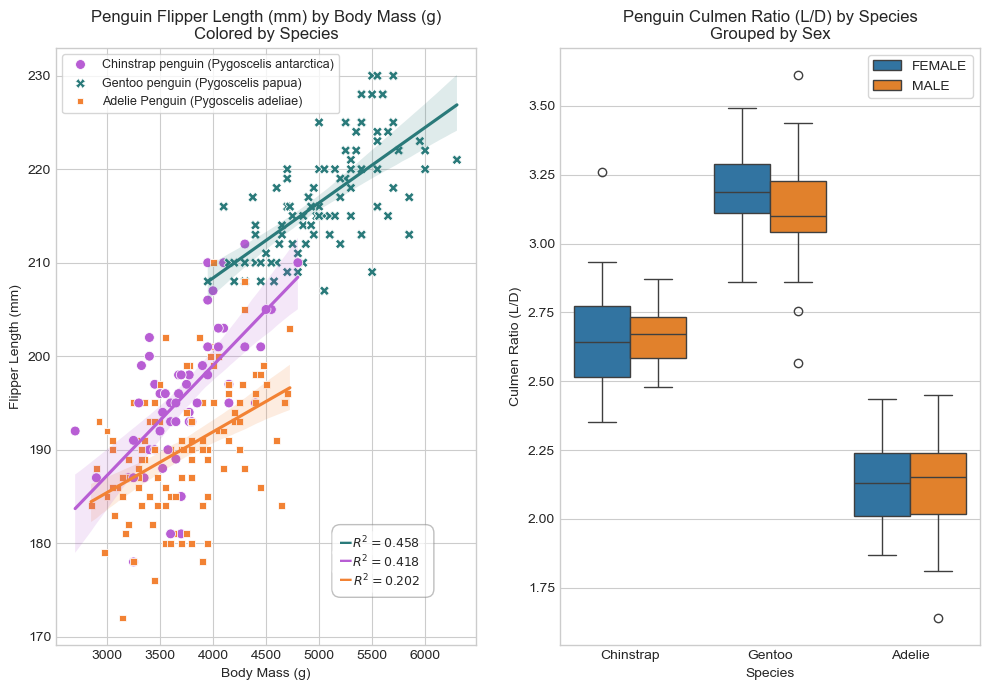

In [27]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize = (10, 7))
plt.style.use("seaborn-v0_8-whitegrid")

# Setting up the initial scatter plot
ax[0] = sns.scatterplot(data = train_viz, x = 'Body Mass (g)', y = 'Flipper Length (mm)', hue = 'Species', palette = ['#B85ED4', '#2A7A7A', '#F28234'], style = 'Species', s = 50, ax = ax[0])

# Adding regression lines for each species
sns.regplot(data = adelie, x = 'Body Mass (g)', y = 'Flipper Length (mm)', scatter = False, line_kws={'color': '#F28234'}, ax = ax[0])
sns.regplot(data = chinstrap, x = 'Body Mass (g)', y = 'Flipper Length (mm)', scatter = False, line_kws={'color': '#B85ED4'}, ax = ax[0])
sns.regplot(data = gentoo, x = 'Body Mass (g)', y = 'Flipper Length (mm)', scatter = False, line_kws={'color': '#2A7A7A'}, ax = ax[0])

# Plot styling to make colors match up and the text boxes look nicer
ax[0].set_title("Penguin Flipper Length (mm) by Body Mass (g)\nColored by Species")
ax[0].legend(frameon = True, prop = {'size': 9})
ax[0].text(5200, 175.75, '           \n', fontsize = 20, bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'grey', boxstyle = 'round, pad=0.3'))
ax[0].text(5555, 180, f'     $R^2 = {rs3:.3f}$', ha = 'center', va = 'center', fontsize = 9, 
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'none', boxstyle = 'round,pad=0.3'))
ax[0].text(5555, 178, f'     $R^2 = {rs2:.3f}$', ha = 'center', va = 'center', fontsize = 9, 
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'none', boxstyle = 'round,pad=0.3'))
ax[0].text(5555, 176, f'     $R^2 = {rs1:.3f}$', ha = 'center', va = 'center', fontsize = 9, 
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'none', boxstyle = 'round,pad=0.3'))
ax[0].text(5200, 180.1, '\u2013', color='#2A7A7A', ha='left', va='center', fontsize=15, fontweight='bold')
ax[0].text(5200, 178.1, '\u2013', color='#B85ED4', ha='left', va='center', fontsize=15, fontweight='bold')
ax[0].text(5200, 176.1, '\u2013', color='#F28234', ha='left', va='center', fontsize=15, fontweight='bold')

# Setting up the box plot and doing some simple styling
ax[1] = sns.boxplot(train_viz, x = "Species", y = "Culmen Ratio (L/D)", hue = "Sex", ax = ax[1])
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(["Chinstrap", "Gentoo", "Adelie"])
ax[1].legend(prop = {'size': 10}, frameon = True)
ax[1].set_title("Penguin Culmen Ratio (L/D) by Species\nGrouped by Sex")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

In the figure to the left, the relationship between penguin flipper length (mm) and body mass (g) for each species of penguin is displayed.  Visually, there appears to be a notable positive, linear relationship between flipper length and body mass in general.  That is, it seems that as penguin body mass increases, the flipper length increases as well regardless of species.  

Additionally, there appears to be some clustering by species shown in this relationship.  Gentoo penguins appear to have both the largest flipper lengths and body masses.  There is less of a visually obvious distinction between Chinstrap and Adelie penguins shown by the relationship between body mass and flipper length.  However, I believe it is reasonable to hypothesize that Chinstrap penguins have a slightly greater average flipper length while Adelie penguins have a slightly greater body mass.  

From the $R^2$ values for the regression lines corresponding to the relationship between body mass and flipper length for each penguin species, I feel that it's reasonable to say the positive linear relationships between the two variables in question for each species range from weak/moderate to moderate in strength.  Further, while I do not have the statistical knowledge to confirm nor deny this hypothesis, perhaps the clear visual difference observed across the three species-specific regression lines could provide useful insight into this classification task.

In general, this plot reveals some useful information about the differences observed across each penguin species from two relevant variables.  While this plot likely does not provide highly convincing information pertaining to the species classification of penguins from certain features, it does highlight a relationship between two key quantitative variables that displays a preliminary approach to this classification task.

The figure to the right displays the general distribution of the `Culmen Ratio (L/D)` feature across penguin sex and penguin species.  The `Culmen Ratio (L/D)` is the ratio of culmen length (mm) to culmen depth (mm).  With no prior knowledge about culmen size and dimensions in penguins, I thought it would be interesting to compute the length-depth ratio for each penguin and see how this ratio differed by sex and across each species.  Observing the comparison of the culmen ratio between male and female penguins, there does not appear to be as much visually obvious information.  However, to me, there appears to be minimal distribution overlap in the culmen ratio across each species.  I believe this suggests that the culmen ratio or related features (culmen length and culmen depth) could be useful in model construction to successfully complete this classification task.

#### Table of General Statistics

In [28]:
# Summary Statistics

# Helper method to calculate coefficient of variation (%)
def cv(col):
    return (col.std() / col.mean()) * 100

# Creating a table grouped by penguin species and sex, showing general summary stats for several quantitative variables
sum_stats = train_viz.groupby(['Species', 'Sex']).aggregate({"Flipper Length (mm)" : ["mean", "std", cv], 
                                                             "Body Mass (g)" : ["mean", "std", cv], "Culmen Length (mm)": ["mean", "std", cv], 
                                                             "Culmen Depth (mm)": ["mean", "std", cv], "Culmen Ratio (L/D)": ["mean", "std", cv]})
sum_stats = sum_stats.rename(columns = {'mean': 'Mean', 'std': 'STD', 'cv': 'CV (%)'})
sum_stats = sum_stats.round(2)
sum_stats

Flipper Length (mm)        \
                                                                Mean   STD   
Species                                   Sex                                
Adelie Penguin (Pygoscelis adeliae)       FEMALE              187.92  5.43   
                                          MALE                192.33  7.00   
Chinstrap penguin (Pygoscelis antarctica) FEMALE              192.06  5.90   
                                          MALE                200.69  6.29   
Gentoo penguin (Pygoscelis papua)         FEMALE              212.84  3.47   
                                          MALE                221.20  5.22   

                                                        Body Mass (g)          \
                                                 CV (%)          Mean     STD   
Species                                   Sex                                   
Adelie Penguin (Pygoscelis adeliae)       FEMALE   2.89       3350.47  262.87   
                                          MALE     3.64       4052.87  331.57   
Chinstrap penguin (Pygoscelis antarctica) FEMALE   3.07       3523.39  294.95   
                                          MALE     3.13       4005.77  368.53   
Gentoo penguin (Pygoscelis papua)         FEMALE   1.63       4684.69  297.46   
                                          MALE     2.36       5476.70  301.32   

                                                        Culmen Length (mm)  \
                                                 CV (%)               Mean   
Species                                   Sex                                
Adelie Penguin (Pygoscelis adeliae)       FEMALE   7.85              37.43   
                                          MALE     8.18              40.40   
Chinstrap penguin (Pygoscelis antarctica) FEMALE   8.37              46.72   
                                          MALE     9.20              51.33   
Gentoo penguin (Pygoscelis papua)         FEMALE   6.35              45.46   
                                          MALE     5.50              49.01   

                                                               \
                                                   STD CV (%)   
Species                                   Sex                   
Adelie Penguin (Pygoscelis adeliae)       FEMALE  1.95   5.20   
                                          MALE    2.37   5.86   
Chinstrap penguin (Pygoscelis antarctica) FEMALE  3.17   6.78   
                                          MALE    1.60   3.13   
Gentoo penguin (Pygoscelis papua)         FEMALE  1.97   4.34   
                                          MALE    2.29   4.68   

                                                 Culmen Depth (mm)        \
                                                              Mean   STD   
Species                                   Sex                              
Adelie Penguin (Pygoscelis adeliae)       FEMALE             17.64  0.92   
                                          MALE               19.08  1.05   
Chinstrap penguin (Pygoscelis antarctica) FEMALE             17.61  0.80   
                                          MALE               19.27  0.77   
Gentoo penguin (Pygoscelis papua)         FEMALE             14.21  0.54   
                                          MALE               15.73  0.79   

                                                        Culmen Ratio (L/D)  \
                                                 CV (%)               Mean   
Species                                   Sex                                
Adelie Penguin (Pygoscelis adeliae)       FEMALE   5.21               2.13   
                                          MALE     5.48               2.12   
Chinstrap penguin (Pygoscelis antarctica) FEMALE   4.55               2.66   
                                          MALE     3.97               2.67   
Gentoo penguin (Pygoscelis papua)         FEMALE   3.78               3.20   
                  

*In creating the table above, I looked up how to calculate the CV for each of the columns to more easily interpret the STD and created the helper method*

Above is a general statistics table for the quantitative features present in the penguins data.  Some noteworthy observations from this table are below.

Adelie penguins:

-   Females
    -   Smallest average flipper length, body mass, culmen length, and culmen ratio
    -   Largest average culmen depth
-   Males
    -   Smallest average flipper length, culmen length, and culmen ratio

Chinstrap penguins:

-   Females
    -   Largest average culmen length
-   Males
    -   Smallest average body mass
    -   Largest average culmen length and culmen depth

Gentoo penguins:

-   Females
    -   Largest average flipper length, body mass, and culmen ratio
    -   Smallest average culmen depth
-   Males
    -   Largest average flipper length, body mass, and culmen ratio
    -   Smallest average culmen depth

Regarding the variability in the distribution of each feature represented in the table above, the coefficient of variation (as a percentage) is below 10% for all feature distributions.  According to some [brief research](https://www.investopedia.com/terms/c/coefficientofvariation.asp#toc-coefficient-of-variation-cv-vs-standard-deviation) on CV, the CV values shown in the table above suggest that there is a relatively low degree of variability in the distributions of each feature.

# Feature Selection
Per the guidelines of this post, I conducted a feature selection process to pick the two "best" quantitative features and the single "best" qualitative feature.  I used the `SelectKBest(...)` feature selection method from the `sklearn.feature_selection` package.  For the quantitative feature selection, I identified all the quantitative columns in the training data and used `SelectKBest(...)` on a quantitative-column-only subset of the training data using $k = 2$ (the number of features to select).  I repeated this process to select the best qualitative feature.  For the qualitative feature selection, I set $k = 3$ to account for cases of several qualitative columns technically being part of the same feature.  For example, in my case, `Island` was the selected qualitative feature, but in the training data, there are three `Island` columns: `Island_Biscoe`, `Island_Dream`, and `Island_Torgersen`.  Setting $k = 3$ allowed the selection process to include all three `Island` columns.

*Note: I experimented with values for k during the qual feature selection.  I found that if k < 3, only 1 or 2 (depending on k) of the island cols were selected.  If k > 3, all three island cols were selected and then other qual features were selected for the remaining (k - 3) features.  Thus I concluded that `Island` was the best qual feature and set k = 3 to collect all three `Island` cols.*

In [29]:
# Identifying all quantitative and qualitative columns
qual_cols = ['Clutch Completion_No', 'Clutch Completion_Yes', 'Sex_FEMALE', 'Sex_MALE', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Stage_Adult, 1 Egg Stage']
quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

# Selecting the best two quantitative features and the best qualitative feature (following steps from sklearn docs)
quant_select = SelectKBest(k = 2)
qual_select = SelectKBest(k = 3)
quant_select.fit(X_train[quant_cols], y_train)
qual_select.fit(X_train[qual_cols], y_train)
quant_select.transform(X_train[quant_cols])
qual_select.transform(X_train[qual_cols])
quant_features = X_train[quant_cols].columns[quant_select.get_support()]
qual_features = X_train[qual_cols].columns[qual_select.get_support()]
quant_features = list(quant_features)
qual_features = list(qual_features)
X_train_selected = X_train[quant_features + qual_features]

/Users/colmcd/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/colmcd/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# Model Training and Refining

The model I chose for this classification task is the `RandomForestClassifier` model from the `sklearn.ensemble` package.  Off the bat, the base model (with no cross-validation) displayed a training accuracy of $100\%$ (noice!).  But, to prevent the model from too much overfitting, I fine-tuned the `max_depth` parameter to adjust the complexity of the model tree.  Using the arbitrary range* of $[1, 30]$, I iteratively determined the optimal `max_depth` by: 
    
-   Creating a new model at each iteration with the `max_depth` set to the next value in the depth range
-   Fitting the new model to the training data
-   Calculating the average cross-validation score (with 10 folds) for the current model
-   Compared the current avg. cross. val. score to the current best avg. cross. val. score
-   Updated the best avg. cross. val. score and best depth value if the current model outperformed the previous best.

**I also tried setting `max_depth` to `None` to see if no specified value would be optimal.  This turned out not to be the case*

After this process, I created one last `RandomForestClassifier` model named `rfc_refined` with the optimal `max_depth` value.  I then trained and scored this model with the training data and it too displayed nearly $100\%$ ($99.609\%$) accuracy.

In [30]:
# Base model - no parameter tuning or overfitting guarding
rfc_base = RandomForestClassifier(random_state = 69)
rfc_base.fit(X_train_selected, y_train)
base_score = rfc_base.score(X_train_selected, y_train)
print(f'Base Model Training Accuracy: {base_score * 100: .3f}%')

# Refining model with cross validation - adjusting the max_depth param
## Picking a depth range value (and including a null depth value)
depths =  list(range(1, 31)) + [None]

# Initializing variables to be updated
best_depth = 0
best_avg_score = 0
for depth in depths:
    
    # Constructing a fresh model with the current depth value and evaluating it's performance after cross-validation
    rfc = RandomForestClassifier(random_state = 69, max_depth = depth)
    rfc.fit(X_train_selected, y_train)
    curr_avg_score = cross_val_score(rfc, X_train_selected, y_train, cv = 10).mean()
    
    # Updating the key variables if necessary
    if (curr_avg_score > best_avg_score):
        best_depth = depth
        best_avg_score = curr_avg_score

rfc_refined = RandomForestClassifier(random_state = 69, max_depth = best_depth)
rfc_refined.fit(X_train_selected, y_train)
refined_score = rfc_refined.score(X_train_selected, y_train)
print(f'Refined (cross-validated) Model Training Accuracy: {refined_score * 100: .3f}%')

Base Model Training Accuracy:  100.000%
Refined (cross-validated) Model Training Accuracy:  99.609%


## Testing the Model

After refining my model, I then tested it on the testing data.  To my excitement, the model dispayed a $98.529\%$ testing accuracy.

In [31]:
# Accessing test data
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

# Testing the model!
X_test, y_test = prepare_data(test)
test_score = rfc_refined.score(X_test[X_train_selected.columns], y_test)
ts2 = rfc_base.score(X_test[X_train_selected.columns], y_test)
print(f'Refined (cross-validated) Model Test Accuracy: {test_score * 100: .3f}%')

Refined (cross-validated) Model Test Accuracy:  98.529%


Below are the decision regions determined by the model for both the training and testing data.  Visually, the decision regions for the training and testing data appear to be extremely similar.  Additionally, I feel that it is reasonable to state that the decision regions for both the training and testing data do not display a high degree of model-overfitting. 

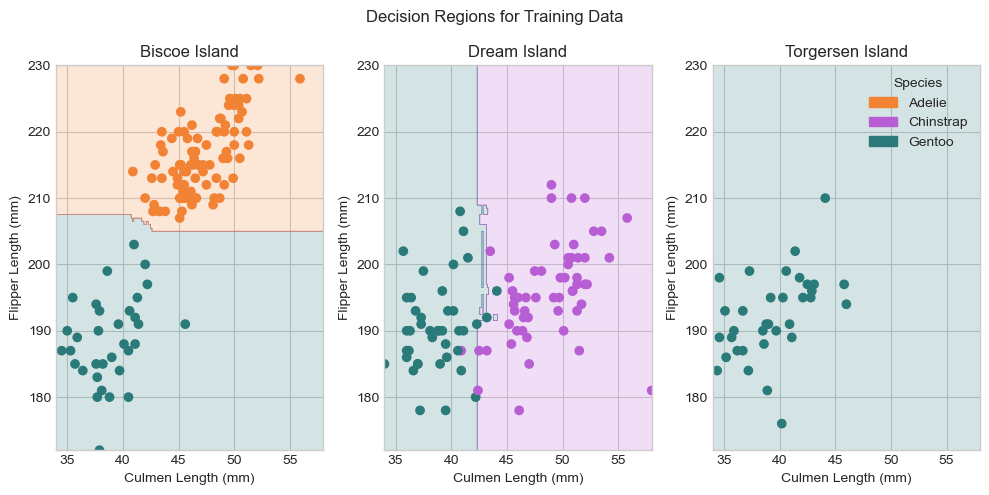

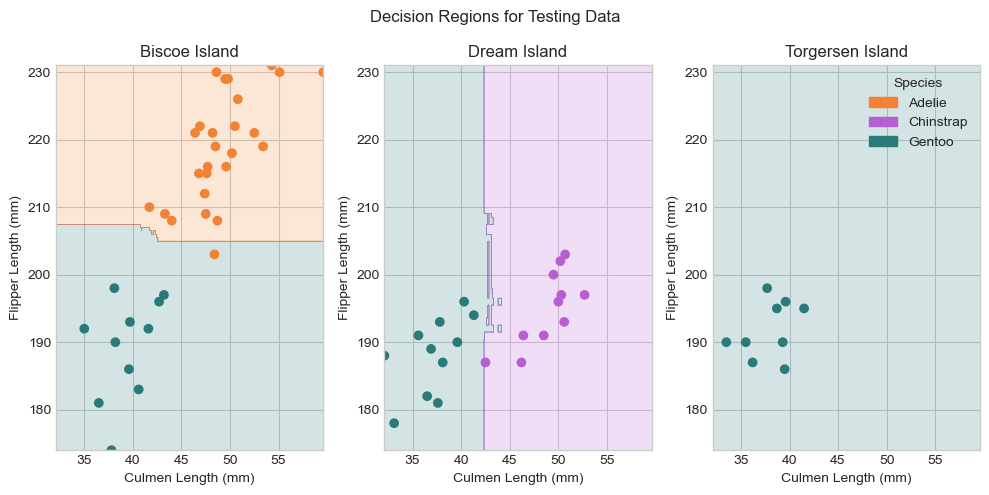

In [32]:
# Decision region plotting - code provided by Prof. Chodrow
def plot_regions(model, X, y, type):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (10, 5))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      colors = ['#2A7A7A', '#B85ED4', '#F28234']
      og = ['red', 'green', 'blue']
      cmap = ListedColormap(colors)
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = cmap, alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = cmap, vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i][7:] + " Island")
      
      patches = []
      for color, spec in zip(['#F28234', '#B85ED4', '#2A7A7A'], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")

      if (type):
         fig.suptitle("Decision Regions for Training Data")
      else:
         fig.suptitle("Decision Regions for Testing Data")
      
      plt.tight_layout()

plot_regions(rfc_refined, X_train_selected, y_train, 1)
plot_regions(rfc_refined, X_test[X_train_selected.columns], y_test, 0)

*I made some minor adjustments to the code above provided by Prof. Chodrow (primarily debugging, color changing, and adding titles)*

## Confusion Matrix for the Model

Below is the confusion matrix to evaluate the model's testing performance.  As expected with $< 100\%$ ($98.529\%$) testing accuracy, the confusion matrix has at least some (in this case exactly 1) non-zero entries off the diagonal.  This indicates that the model made 1 misclassification.  That is, all Adelie penguins and Chinstrap penguins were correctly classified, but there was one Gentoo penguin who was misclassified as an Adelie penguin (shucks).

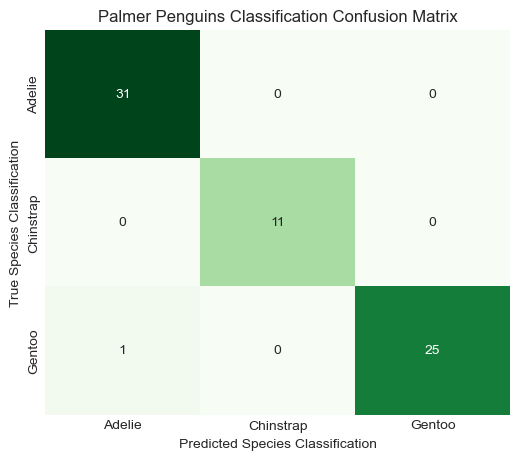

There were 31 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 11 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 1 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were

In [33]:
# Establishing model predictions for the test data
y_test_pred = rfc_refined.predict(X_test[X_train_selected.columns])
C = confusion_matrix(y_test, y_test_pred)
species = ["Adelie", "Chinstrap", "Gentoo"]

# Creating a heatmap for better confusion matrix visualization
plt.figure(figsize=(6, 5))
sns.heatmap(C, annot = True, fmt = "d", cmap = 'Greens', cbar = False, xticklabels = species, yticklabels = species)

# Setting labels and title
plt.xlabel("Predicted Species Classification")
plt.ylabel("True Species Classification")
plt.title("Palmer Penguins Classification Confusion Matrix")

plt.show()

# Printing confusion matrix results
for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguin(s) who were classified as {le.classes_[j]}.")

# Discussion

As explained in the sections above, the eventual model chosen for this penguin species classification task was a random forest classifier from `sklearn`.  In the process of fine-tuning my model, I learned about the significance of; using a constant `random_state` parameter to ensure consistent random behavior across iterative model constructions; and adjusting the`max_depth` parameter alongside cross-validation to build a less overfitting-prone final model.  

The results of my feature selection process determined that the optimal three features to fit my model to were flipper length (quant), culmen length (quant), and resident island (qual).  Intuitively, I’m led to believe that my feature selection process indicates that flipper length, culmen length, and resident island are some of the most effective features to analyze for penguin species classification.  This is also supported by the model’s near-flawless classification performance on unseen testing data after being trained on these three features.  

As far as penguin classification goes, it appears that more quantitative measurements such as flipper length and culmen length are more informative than general quantitative features like body mass.  Additionally, consulting a penguin’s region of residence seems to be considerably useful in the classification of its species (I ultimately do not find this surprising).  Of course, I acknowledge that the findings from this brief analysis are highly dependent on the features used during data collection.  I want to acknowledge that taking this model to classify penguins from other datasets may yield poor results or fail entirely.

Regardless, this analysis offered me a digestible yet intriguing introduction to classification problems solved with machine learning tools.  In this analysis, I was able to explore the behavior of a model family entirely new to me.  While there are numerous additional parameters to adjust with the model I chose that I did not touch, tweaking my model in the ways discussed above provided me with an opportunity to observe and experience how iterative model refinement processes can work.  Additionally, this analysis introduced me to feature selection practices, giving me hands-on experience with feature selection using prebuilt tools and systems.  Lastly, this analysis was a fantastic opportunity for me to gain more familiarization with the various Python libraries that I’ll be exploring much more over the course of the semester.  From plotting, to modeling, to printing, this blog post gave me some great machine-learning programming practice.


*During the implementation process of this blog post, I collaborated with Omar Armbruster and Andrew Dean.*